In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data import *
from utils import *
from NMF import *
import pandas as pd
import seaborn # For nice plots
from copy import deepcopy
import warnings
import time
warnings.filterwarnings("ignore")

Implementation details
---

Handling of data is done in data.py. Tensorflow/keras is used to load data. As long as these packages are installed, the experiments here should be replicated by any computer.


<h3> Initialization </h3>

We primarily use exemplar-based initialization, which means that to initialize $W$ we sample $d$ columns of $U$, and then initialize $H$ via projection.
This is also used in the cases where $W$ is already pre-trained, and we want to train either adversarially or discriminatively. In the cases where this is infeasible, we use randomized initialization, where we sample from a uniform distribution. 

<h3> Stochastic multiplicative updates with several datasets </h3>
When applying stochastic multiplicative updates to ANMF and D+ANMF we face the challenge that we are minimizing a loss with
different terms and potentially unbalanced data. This means that we can, and most likely should, select different batch sizes for the different datasets.
Some potential strategies for this selection are the following:

- *Proportional sampling*: Select the batch sizes proportional to the size of the datasets, in which case the number of batches are also equal. 
- *Undersampling*: End the epoch and reshuffle all data when we have passed through all batches of the dataset with the smallest number of batches.
- *Oversampling*: When all batches of one dataset have been passed through, resample the data-points from this dataset until all batches of the other datasets have been passed through.
- *Iterative sampling*: Reshuffle only the corresponding data when we have passed through all batches of this dataset. In this case each dataset has its corresponding number of epochs.

All approaches have their advantages and disadvantages, but we propose using undersampling and oversampling as they are simple to implement
while still allowing different batch sizes for the different terms.
Specifically, we first select which dataset we are interested in sampling fully, and then either
undersample or oversample the other data. 
For oversampling, we sample circularly, starting from the first data-points when we have passed through all data.

<h3> Potential improvements </h3>
The implementation of the algorithms provided here are suitable for small scale problems. 
One major drawback with ANMF and D+ANMF is that we have to update latent variables for data that are unimportant for the overall fit.
There are some ways to circumvent this:
 
- Use only a subset of the data for fitting. We experimentally found that this can safely be done without altering the results too much. This is also the case in general in data-rich settings for standard NMF. Because the data is not just used for the update of $W$, but also for the latent variables $H$, it can be much more computationally efficient to only use a subset of the data without altering the overall results. An interesting extra application would be automatic identification of data that do not contribute to the overall fit that can safely be removed.
- Because we are updating in batches, another option is to only update the data that was used in the updates. However, we found that this was experimentally unstable, and difficult to coordinate with normalization.
- When applying cross-validation (CV) for parameter tuning, it is natural to divide the strong supervision data into CV folds, but it is unclear if it is a better approach to also divide the weak supervision data into CV folds. This would of course have a computational benefit, but with generative models more data is usually better, and especially for low complexity methods like NMF there is no problem of overfitting weak superivison data. In fact, we experimentally observe that not dividing into CV folds, but instead utilizing all data available can actually be beneficial. We suspect that the value of fitting with more data outweighs the drawback of overfitting specific data for low complexity methods. In the code, we do divide strong superivision data into CV folds, but utilize all weak supervision data for fitting each fold. This means that parameter tuning for D+ANMF is drastically more computationally expensive than the other methods.


With ANMF, one of the challenges for the implementation is that true data from one source is also needed as adversarial data for another source,
and the mixed data is needed to train all sources. The bases can still be fitted independently, in principle even in parallel,
if we copy the relevant adversarial data for each source.
With D+ANMF, a parallel implementation is further complicated by the fact that we can no longer fit the latent variables independently for each source.
An efficient implementation of D+ANMF for large scale datasets can therefore be challenging and
is outside the scope of this paper.


Convergence experiment
---
We start by analyzing the convergence properties of
the multiplicative update algorithm as well as its stochastic variant.
In all experiments we generate data synthetically.
Although the methods are easily applicable to settings with more sources,
we only consider separating mixtures of two sources.
We generate data by sampling random images from the different classes and mixing
them with deterministic weights $a_0 = a_1 = 0.5$.
Initially, we only mix ``zero'' and ``one'' digits, as
these numbers yield decent separation and reconstruction results for NMF-based methods.
Especially ``one'' digits can be reconstructed reasonably well with non-negative bases.
For other digits, the lacking complexity of the NMF bases is more evident, and they are more difficult to both separate and reconstruct.

We synthetically generate $N = 2500$ strong supervised data, and use sparsity parameters $\mu_W = \mu_H = 10^{-10}$. For ANMF and D+ANMF we use $\tau_A = 0.1$,
and for D+ANMF we use $\tau_S = 0.5$. For ANMF we use both data from other sources and mixed data as adversarial data, and for D+ANMF we use the
strong supervised data for both the strong supervised and the weak supervised term.

We begin by illustrating the convergence of our proposed algorithm for different batch sizes. 
We only report the convergence for the basis and latent variables for one source for all methods, including DNMF and D+ANMF which are fitted for all other sources at the same time.


In [2]:
"""
Load image data.
"""

np.random.seed(0)
mnist = MNIST()

# Digits to be used
Ms = [0,1]
M = len(Ms)

# Amount of data used
N_sup = 2500
N_sup_test = 0

mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, type = "det", weights = [1.0/M] * M)

V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
U_sup = []
U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)
U_test_fit = []
for i in range(M):
    U_sup.append(U_s[:,i,:])
    U_test_fit.append(U_test[:,i,:])
V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)

2023-04-20 13:41:59.650196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Convergence of NMF 
np.random.seed(0)
plt.rcParams.update({'font.size': 14})

batch_size = [50,500,1000,2500]
linestyles = ['dashdot']*10
times = []
loss_stds = []
for i,b in enumerate(batch_size):
    tick = time.time()
    nmf = NMF(d = 64, epochs = 100, batch_size = b, mu_W = 1e-10, mu_H = 1e-10, normalize = True)
    loss_stds.append(nmf.fit_std(U_r = U_sup[0],conv = True))
    tock = time.time()
    times.append(tock-tick)
print(times)

[8.819432973861694, 4.5977489948272705, 4.029049873352051, 4.288003206253052]


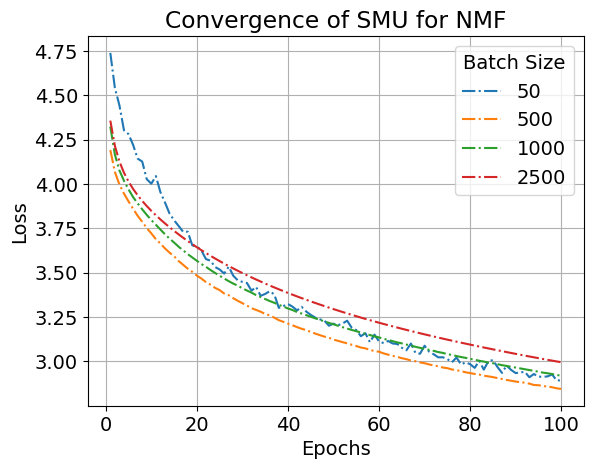

In [4]:
# Plotting
for i,b in enumerate(batch_size): 
    plt.plot(np.arange(1,101), loss_stds[i][1:],label = f"{b}", linestyle = linestyles[i])
plt.legend(title = "Batch Size", loc = "upper right")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title(f"Convergence of SMU for NMF")
plt.grid()
#plt.savefig("fig/std_conv.png")
plt.show()

In [5]:
# Convergence of Adversarial NMF
plt.rcParams.update({'font.size': 14}) 
np.random.seed(0)

batch_size = [500,500,1000,2500]
batch_size_z = [100,250,500,5000]
linestyles = ['dashdot']*10
times = []
loss_advs = []

for i,b in enumerate(batch_size):
    tick = time.time()
    nmf_sep = NMF_separation(ds = [64,64], epochs = 100, prob = "adv", true_sample = "std", normalize = True, update_H = False,
        mu_W = 1e-10, mu_H = 1e-10, batch_size = batch_size[i], batch_size_z = batch_size_z[i], tau_A = 0.1)
    U_z = nmf_sep.create_adversarial(U_sup, V_sup)
    loss_advs.append(nmf_sep.NMFs[0].fit_adv(U_r = U_sup[0], U_z = U_z[0], conv = True))

    tock = time.time()
    times.append(tock-tick)
print(times)


[10.318918943405151, 13.773966789245605, 11.171460151672363, 13.354871034622192]


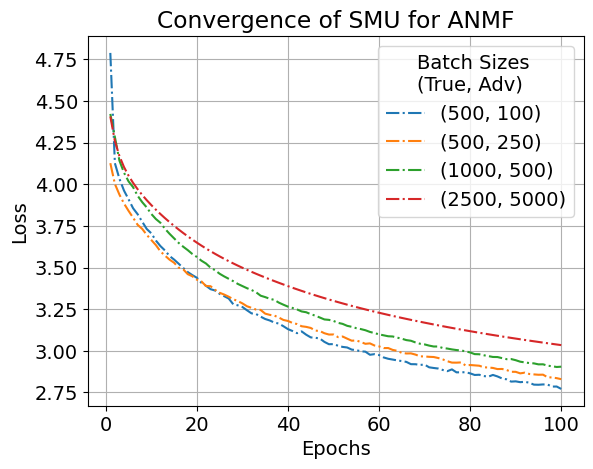

In [6]:
# Plotting
for i, b in enumerate(batch_size): 
    plt.plot(np.arange(1,len(loss_advs[i])), loss_advs[i][1:],label = f"({b}, {batch_size_z[i]})", linestyle = linestyles[i])
plt.legend(title = r"Batch Sizes " + "\n" + "(True, Adv)")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Convergence of SMU for ANMF")
plt.grid()
#plt.savefig("fig/adv_conv.png")
plt.show()


In [7]:
# Convergence of discriminative NMF
np.random.seed(1)
plt.rcParams.update({'font.size': 14}) 

batch_size_sup = [50,500,1000,2500]
linestyles = ['dashdot']*10
ds = [64,64]
times = []
loss_sups = []
for i,b in enumerate(batch_size_sup):
    tick = time.time()
    nmf = NMF(d = np.sum(ds), ds = ds, epochs = 100, mu_W = 1e-10, mu_H = 1e-10, warm_start_epochs = 10,batch_size_sup = b, normalize = True)
    loss_sups.append(nmf.fit_sup(U_sup = U_sup, V_sup = V_sup, conv = True))
    tock = time.time()
    times.append(tock-tick)
print(times)

[18.548322200775146, 8.960050821304321, 8.791993856430054, 9.258413791656494]


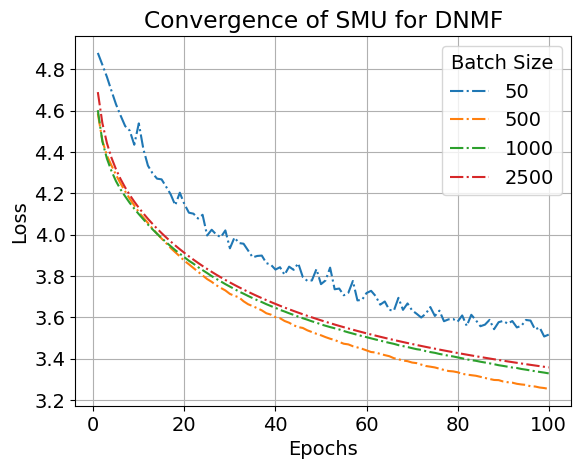

In [8]:
# Plotting
for i, b in enumerate(batch_size_sup):
    plt.plot(np.arange(1,101),loss_sups[i][0,1:],label = f"{b}", linestyle = linestyles[i])
plt.legend(title = "Batch Size", loc = "upper right")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Convergence of SMU for DNMF")
plt.grid()
#plt.savefig("fig/sup_conv.png")
plt.show()

In [9]:
# Convergence of D+ANMF
plt.rcParams.update({'font.size': 14}) 
np.random.seed(0)

batch_size_r = [500,100,1000,2500]
batch_size_z = [100, 100, 250, 5000]
batch_size_sup = [100, 500, 1000, 2500]
linestyles = ['dashdot']*10
times = []
loss_fulls = []
for i,b in enumerate(batch_size_r):
    tick = time.time()
    nmf_sep = NMF_separation(ds = [64,64], epochs = 100, mu_W = 1e-10, mu_H = 1e-10, prob = "full",
        batch_size = batch_size_r[i], batch_size_z = batch_size_z[i], batch_size_sup = batch_size_sup[i], tau_A = 0.05, tau_S = 0.5,
        true_sample = "sup")
    U_z = nmf_sep.create_adversarial(U_sup, V_sup)
    loss_fulls.append(nmf_sep.NMF_concat.fit_full(U_r = U_sup, U_z = U_z, U_sup = U_sup, V_sup = V_sup, conv = True))
    tock = time.time()
    times.append(tock-tick)
print(times)
    

[63.130638122558594, 38.024059772491455, 37.66616868972778, 39.19717788696289]


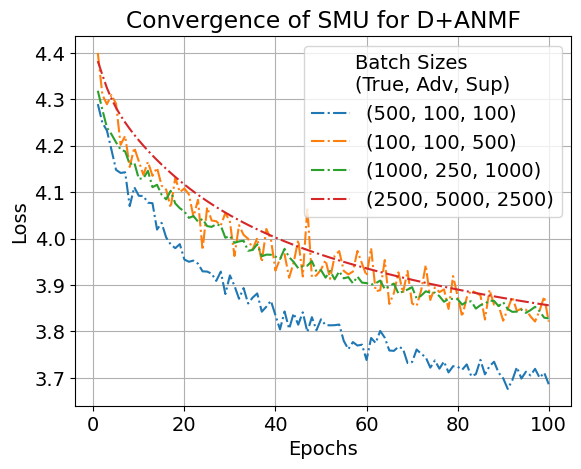

In [10]:
# Plotting
for i, b in enumerate(batch_size_r):
    plt.plot(np.arange(1,101),loss_fulls[i][0,1:],label = f"({b}, {batch_size_z[i]}, {batch_size_sup[i]})", linestyle = linestyles[i])
plt.legend(title = "Batch Sizes" + '\n' + "(True, Adv, Sup)")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Convergence of SMU for D+ANMF")
plt.grid()
#plt.savefig("fig/full_conv.png")
plt.show()

The proposed methods converge in the sense that the epochs reduce the loss we are minimizing. The results imply that selecting smaller batch sizes
can lead to faster convergence, though at the cost of random fluctuations, particularly for very small batch sizes. We also observe that the batch size of the adversarial term can safely be chosen small without harming convergence speed, likely because $\tau_A$ is small as well.

Data rich experiment
---


In this experiment we want to test the proposed methods in a setting where we have a lot of strong supervised data to see how the data settings compare. We test this on $0$ and $1$ digits, as NMF performs relatively well in this situation. We select $N_0 = N_1 = 5000$ data of each source and $N_\text{test} = 1000$ test data.
We use the sparsity parameters $\mu_H = 10^{-6}$ and $\mu_W = 10^{-8}$.
The performance of the methods does not heavily depend on $\mu_H$ and $\mu_W$, 
but larger values mostly harm performance for all methods.
This is because we are working with relatively low $d$, so each atom of the dictionary is required to fully
reconstruct data. 

We use $100$ training epochs, and $100$ test epochs.
Using more training epochs can be slightly beneficial for ANMF in experiments,
but it is actually detrimental to the performance of standard NMF.
We observe that using few training epochs has a regularizing effect, and can lead to much better results
for source separation. 
For ANMF we use $\tau_A = 0.1$. 
We use both data from other sources and mixed data as adversarial data, which means that $\hat{N}_0 = \hat{N}_1 = 10000$.
Moreover, we choose the parameters $\alpha$ and $\beta$ as outlined in the paper.

The batch sizes are selected as $(500,100,500)$ for the true, adversarial and supervised data, respectively, motivated by the convergence results for these values.  
We use the bases from standard NMF as warm start for ANMF and DNMF, with the idea that ANMF and DNMF can be used
to tune an already trained model to more specific data. We repeat the experiment on the same data for different numbers of basis vectors $d$, that we select to be the same for both sources. 

In [49]:
# Parameters for experiment
np.random.seed(1)
number_of_experiments = 1
M = 2
Ms_all = [0,1]
N_sup = 5000
N_sup_test = 1000
mu_W = 1e-8
mu_H = 1e-6

epochs = 100
test_epochs = 100
batch_size = 500
batch_size_sup = 500
batch_size_z = 100
wiener = True

Ds = [16,32,48,64,80,96,112,128]

probs = ["std", "adv","sup","exem"]

df = pd.DataFrame(columns = ["id", "d", "prob", "mean_psnrs"])

taus = [0.0,0.1,0.0,0.0]

for ex in range(number_of_experiments):
    Ms = np.random.choice(Ms_all, M, replace = False)

    # Generate data
    mnist = MNIST()

    mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, type = "det", weights = [1.0/M] * M)
    V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
    U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
    U_sup = []
    for i in range(M):
        U_sup.append(U_s[:,i,:])

    V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)
    U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)

    # arrays to store results
    # Each problem, each source, each data
    psnrs = np.zeros((len(probs), M, len(Ds), N_sup_test)) 
  
    seps = []
    for j,d in enumerate(Ds):
        print("Running experiment with d = ", d)
        for i, prob in enumerate(probs):

            # Fit
            sep = NMF_separation(ds = [d] * M, tau_A = taus[i], normalize = True, update_H = False, true_sample = "std",
                epochs = epochs,prob = prob, 
                mu_W = mu_W, mu_H = mu_H, test_epochs = test_epochs, wiener = True,
                batch_size = batch_size, batch_size_z = d, batch_size_sup = batch_size_sup)

            # Use standard NMF as initial conditions
            if prob == "adv" or prob == "sup":
                for k in range(M):
                    sep.NMFs[k].W = np.copy(stdWs[k])

            if prob == "std" or prob == "exem" or prob == "adv": 
                sep.fit(U_r = U_sup, V = V_sup)
            else:
                sep.fit(U_sup = U_sup, V_sup = V_sup)

            if prob == "std":
                stdWs = []
                for k in range(M):
                    stdWs.append(sep.NMFs[k].W)

            # Separate
            out = sep.separate(V_test)

            # Measure quality SHOULD USE eval member function of sep
            psnrs[i,:,j,:] = PSNR(U_test,out)

            df = pd.concat([df, pd.DataFrame({"d": [d]*N_sup_test, "id": np.arange(0,N_sup_test), "prob": [prob]*N_sup_test, "mean_psnrs": np.mean(psnrs[i,:,j,:],axis = 0)})])
            seps.append(deepcopy(sep))

df.to_csv('csv/data_rich.csv')

Running experiment with d =  16
Running experiment with d =  32
Running experiment with d =  48
Running experiment with d =  64
Running experiment with d =  80
Running experiment with d =  96
Running experiment with d =  112
Running experiment with d =  128


UsageError: Line magic function `%plt.savefig("fig/Data_rich.pdf")` not found.


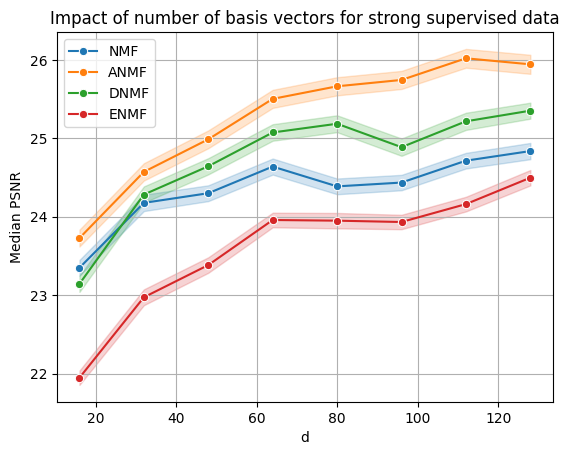

In [52]:
# Plotting
data_rich_df = pd.read_csv('csv/data_rich.csv', index_col = 0)
plt.rcParams.update({'font.size': 10}) 
seaborn.lineplot(data_rich_df, x = "d", y = "mean_psnrs", hue = "prob", 
    estimator = "median", errorbar = "se", markers = True, dashes = True ,
    marker = 'o',legend=False)
plt.grid()
plt.ylabel("Median PSNR")
plt.legend(labels = ["NMF", "_nolegend_" , "ANMF", "_nolegend_", "DNMF", "_nolegend_", "ENMF"])
plt.title("Impact of number of basis vectors for strong supervised data")
%plt.savefig("fig/Data_rich.pdf")
plt.show()

We see that ANMF outperforms all other methods, and performance increases with $d$.
The fact that ANMF outperforms DNMF is somewhat unexpected
This may be due to the fact that DNMF, though optimized for
this specific source separation problem, is not optimized
for the post-processing with the Wiener-filter.
Also, it seems that DNMF training is less stable, and we are
more likely to end up in unfavorable local minimizers. We particularly see this for $d = 96$ in the above plot.
Next, the larger number of hyperparameters favor ANMF over DNMF,
a topic we will investigate further in the next experiment.
Lastly, it is possible that DNMF is more sensitive to overfitting the training data
and that the specific train--test split yields unfavorable results for DNMF. 
However, even though we do observe that there is some variance with respect
to the train--test data split and the parameters, the behavior of the different methods is consistent, with DNMF behaving more erratically than the other methods. 

Data rich - Specific example
---

We now plot a specific data point.

In [50]:
# Pick trained model corresponding to a certain amount of basis vectors 
seps_ = seps[12:16]
for sep in seps_:
    sep.wiener = True
    print(sep.prob, sep.ds)

psnrs_std = seps_[0].eval(U_test[:,:,:], V_test, "psnr" , axis = 0)
psnrs_adv = seps_[1].eval(U_test[:,:,:], V_test, "psnr" , axis = 0)
psnrs_sup = seps_[2].eval(U_test[:,:,:], V_test, "psnr" , axis = 0)
psnrs_exem = seps_[3].eval(U_test[:,:,:], V_test, "psnr", axis = 0)

out_std = seps_[0].separate(V_test[:,:])
out_adv = seps_[1].separate(V_test[:,:])
out_sup = seps_[2].separate(V_test[:,:])
out_exem = seps_[3].separate(V_test[:,:])

diff_adv = []

for i in range(len(psnrs_std)):
    diff_adv.append(psnrs_adv[i]-psnrs_std[i])

ids = np.argsort(diff_adv)

psnrs_std = seps_[0].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)
psnrs_adv = seps_[1].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)
psnrs_sup = seps_[2].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)
psnrs_exem = seps_[3].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)


std [64, 64]
adv [64, 64]
sup [64, 64]
exem [64, 64]


MIX


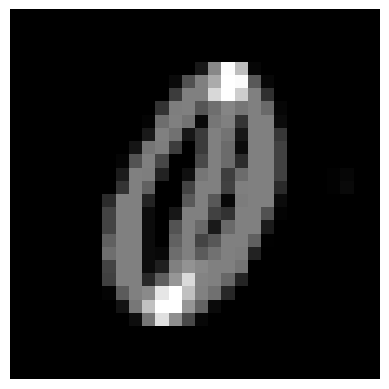

TRUE


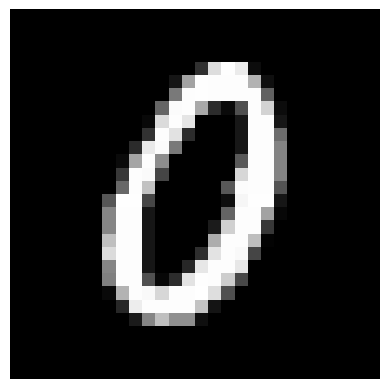

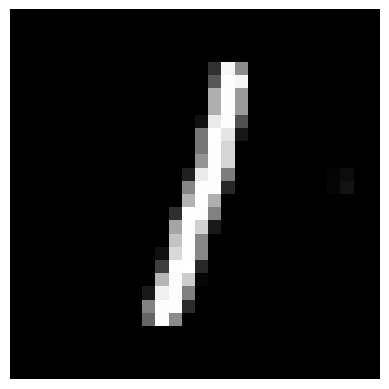

NMF


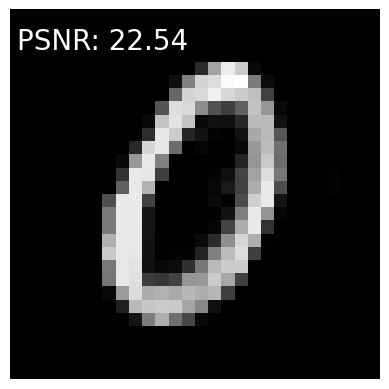

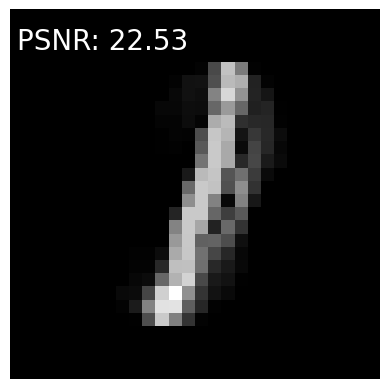

ANMF


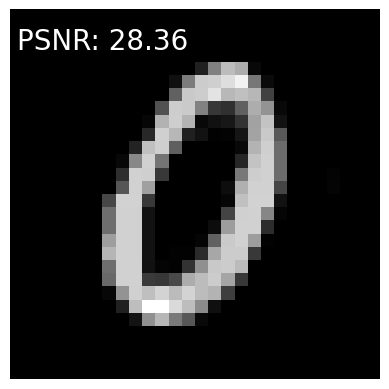

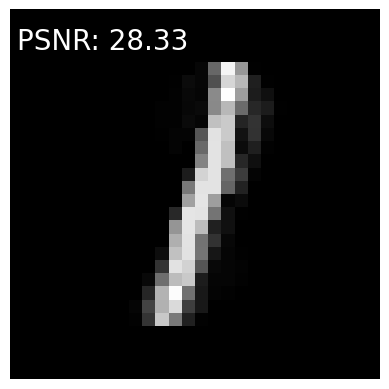

DNMF


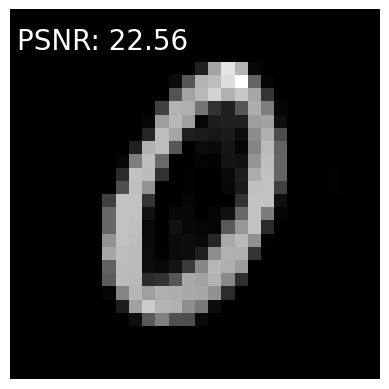

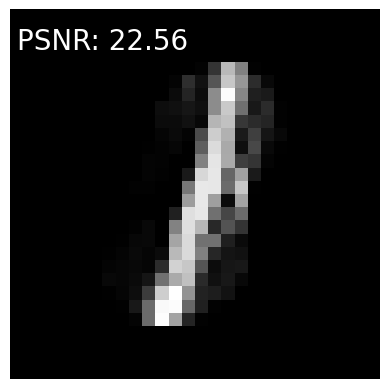

ENMF


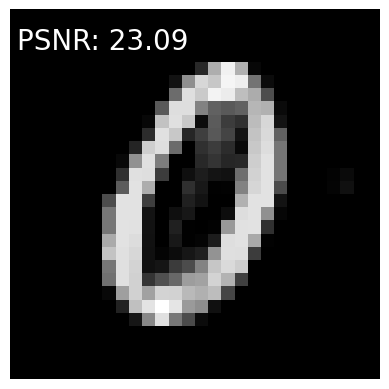

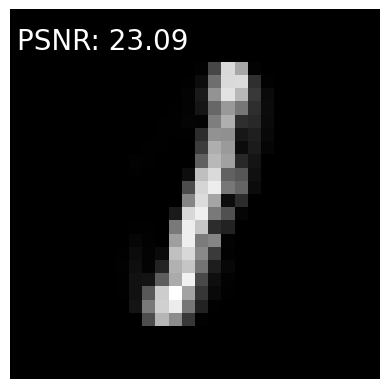

In [55]:
# Select id where adversarial outperforms standard NMF.
# Who needs for loops?

id = ids[-3]
vmin = 0
vmax = 0.5

print("MIX")
plt.imshow(V_test[:,id].reshape((28,28)), cmap = "gray", vmin = vmin)
plt.axis('off')
plt.savefig('fig/v.png', bbox_inches = "tight")
plt.show()

print("TRUE")
plt.imshow(U_test[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
plt.axis('off')
plt.savefig('fig/u0.png', bbox_inches = "tight")
plt.show()

plt.imshow(U_test[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
plt.axis('off')
plt.savefig('fig/u1.png', bbox_inches = "tight")
plt.show()

print("NMF")

fig, ax = plt.subplots()
ax.imshow(out_std[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_std.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_std[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_std_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_std[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u0_std.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_std[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_std_psnr.png', bbox_inches = "tight")
plt.show()

print("ANMF")

fig, ax = plt.subplots()
ax.imshow(out_adv[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_adv.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_adv[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_adv_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_adv[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u0_adv.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_adv[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_adv_psnr.png', bbox_inches = "tight")
plt.show()

print("DNMF")

fig, ax = plt.subplots()
ax.imshow(out_sup[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_sup.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_sup[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_sup_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_sup[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u0_sup.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_sup[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_sup_psnr.png', bbox_inches = "tight")
plt.show()

print("ENMF")

fig, ax = plt.subplots()
ax.imshow(out_exem[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_exem.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_exem[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_exem_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_exem[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_exem.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_exem[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_exem_psnr.png', bbox_inches = "tight")
plt.show()

Data rich - Effect of $\tau_A$
---

We now run an equivalent experiment where we try several values of $\tau_A$. We here use larger batch sizes to stabilize the algorithm, as it can be unstable for large $\tau$.

In [3]:
np.random.seed(1)
number_of_experiments = 1
M = 2
Ms_all = [0,1]
N_adv = 1000
N_sup = 5000
N_sup_test = 1000
mu_W = 1e-8
mu_H = 1e-6

epochs_std = 100
epochs = 100
test_epochs = 100
batch_size = 500
batch_size_sup = 1000
batch_size_z = 500
wiener = True

Ds = [32,64,96,128]

probs = ["std", "adv","adv","adv", "adv", "adv", "adv"]

df = pd.DataFrame(columns = ["id", "d", "prob", "tau", "mean_psnrs"])

taus = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5]

for ex in range(number_of_experiments):
    Ms = np.random.choice(Ms_all, M, replace = False)

    # Generate data
    mnist = MNIST()

    mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, type = "det", weights = [1.0/M] * M)
    V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
    U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
    U_sup = []
    for i in range(M):
        U_sup.append(U_s[:,i,:])

    V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)
    U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)

    # arrays to store results
    psnrs = np.zeros((len(probs), M, len(Ds), N_sup_test)) 

    for j,d in enumerate(Ds):
        print("Running experiment with d = ", d)
        for i, prob in enumerate(probs):

            # Fit
            sep = NMF_separation(ds = [d] * M, tau_A = taus[i], normalize = True, update_H = False, true_sample = "std",
                epochs = epochs_std if prob == "std" else epochs,prob = prob, 
                mu_W = mu_W, mu_H = mu_H, test_epochs = test_epochs, wiener = True,
                batch_size = batch_size, batch_size_z = d, batch_size_sup = batch_size_sup)

            # Use standard NMF as initial conditions
            if prob == "adv" or prob == "sup":
                for k in range(M):
                    sep.NMFs[k].W = np.copy(stdWs[k])
            
            sep.fit(U_r = U_sup, V = V_sup)

            if prob == "std":
                stdWs = []
                for k in range(M):
                    stdWs.append(sep.NMFs[k].W)

            # Separate
            out = sep.separate(V_test)

            # Measure quality SHOULD USE eval member function of sep
            psnrs[i,:,j,:] = PSNR(U_test,out)

            df = pd.concat([df, pd.DataFrame({"d": [d]*N_sup_test, "id": np.arange(0,N_sup_test), "prob": [prob]*N_sup_test, "tau": [taus[i]]*N_sup_test, "mean_psnrs": np.mean(psnrs[i,:,j,:],axis = 0)})])

df.to_csv('csv/data_rich_tau.csv')

Running experiment with d =  32
Running experiment with d =  64
Running experiment with d =  96
Running experiment with d =  128


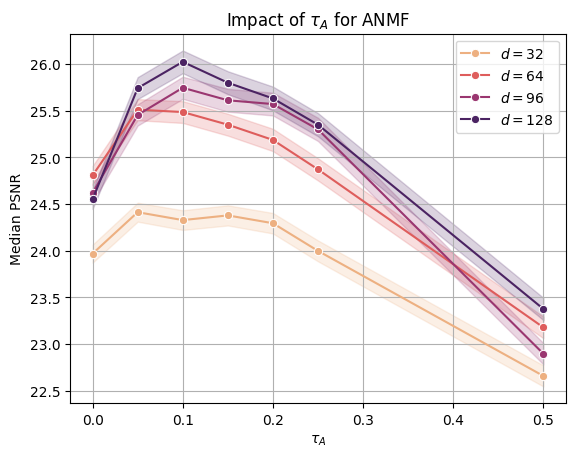

In [11]:
# Plotting
data_rich_tau_df = pd.read_csv('csv/data_rich_tau.csv', index_col = 0)
plt.rcParams.update({'font.size': 10}) 
seaborn.lineplot(data_rich_tau_df.drop(labels="id", axis = 1).dropna(), x = "tau", y = "mean_psnrs", hue = "d",
    estimator = "median", errorbar = "se", markers = True, dashes = True,
    marker = 'o',legend=False, palette = "flare")
plt.grid()
plt.ylabel("Median PSNR")
plt.legend(labels = [r"$d = 32$", "_nolegend_" , r"$d = 64$", "_nolegend_", r"$d = 96$", "_nolegend", r"$d = 128$"])
plt.title("Impact of " + r"$\tau_A$" + " for ANMF")
plt.xlabel(r"$\tau_A$")
plt.savefig("fig/Data_rich_tau.pdf")
plt.show()

We observe that there is a relatively large range of $\tau_A$ values that yield good results, while selecting it too large yields very poor results. Higher model complexity means that there is more flexibility to both learn how to represent true data and not represent adversarial data. This is reflected in the result, as $d = 128$ has the highest difference between standard NMF ($\tau_A = 0$) and good values of $\tau_A$.

Data poor tuning experiment
---

We now do a larger tuning experiment where we have low amounts of data. We select $250$ strong supervised data and $500$ weak supervised data of each source. We mix each digit with a "one"-digit and use random search to find the best parameters for this specific setting.

The code shows what distributions were used for the different hyperparameters. These were chosen mostly to cover a large range of possible parameters, but also with some knowledge of what parameters are relevant for this problem.

In [7]:
np.random.seed(0)
number_of_experiments = 9
number_of_searches = 15
M = 2
Ms_all = [0,2,3,4,5,6,7,8,9]
N_adv = 500
N_V = 0
N_sup = 250
N_sup_test = 1000

# Distributions and parameters used
d_dict = {"name": 'ds', "dist": lambda: [64, 64]}
normalize_dict = {"name": 'normalize', "dist": lambda: np.random.choice([True,False], replace = True)}
mu_H_dict = {"name": 'mu_H', "dist": lambda: np.power(10,np.random.uniform(-10,-3))}
mu_W_dict = {"name": 'mu_W', "dist": lambda: np.power(10,np.random.uniform(-10,-3))}
epochs_dict = {"name": 'epochs', "dist": lambda: np.random.randint(1,100)}
test_epochs_dict = {"name": 'test_epochs', "dist": lambda: np.random.randint(100,150)}
batch_size_r_dict = {"name": 'batch_size', "dist": lambda: np.random.choice([250,500], replace = True)}
batch_size_z_dict = {"name": 'batch_size_z', "dist": lambda: np.random.choice([125,250], replace = True)}
batch_size_sup_dict = {"name": 'batch_size_sup', "dist": lambda: np.random.choice([125], replace = True)}
true_sample_dict = {"name": 'true_sample', "dist": lambda: np.random.choice(["std", "sup"], replace = True)}
tau_A_dict = {"name": 'tau_A', "dist": lambda: np.random.uniform(0.0,0.4)}
tau_S_dict = {"name": 'tau_S', "dist": lambda: np.random.uniform(0.0,0.6)}
betas_dict = {"name": 'betas', "dist": lambda: [np.random.uniform(0.5,1.2), np.random.uniform(0.5,1.2)]} 

probs = ["exem", "std", "adv", "sup", "full"]
results = {"M": [], "exem" : [], "std" : [], "adv" : [], "sup" : [], "full": []}

mnist = MNIST()

for i in range(number_of_experiments):
    print("Running experiment with integer ", i + (i>=1))

    Ms = [1,i + (i>=1)]
    results["M"].append(i + (i>=1))

    mnist.generate_adverserial(Ms = Ms, Ns = [N_adv]*M, N_V = N_V, type = "det", weights = [1.0/M]*M)
    U_r = []
    for i in range(M):
        U_r.append(np.copy(mnist.x_r_train[i][:,:,:].reshape((mnist.Ns_adv[i],784)).T))
    V = np.copy(mnist.x_v_train.reshape((mnist.N_adv_V,784)).T)
    
    mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, type = "det", weights = [1.0/M] * M)
    
    V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
    U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
    U_sup = []
    U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)
    U_test_fit = []
    for i in range(M):
        U_sup.append(U_s[:,i,:])
        U_test_fit.append(U_test[:,i,:])
    V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)


    for prob in probs:

        prob_dict = {"name": 'prob', "dist": lambda: prob}

        if prob == "exem" or prob == "std":
            W_dict = {"name": 'Ws', "dist": lambda: None}

        param_dicts = [d_dict,
            normalize_dict,
            mu_H_dict, 
            prob_dict, 
            mu_W_dict, 
            epochs_dict, 
            test_epochs_dict,
            batch_size_r_dict, 
            batch_size_z_dict, 
            batch_size_sup_dict,
            tau_A_dict,
            tau_S_dict,
            true_sample_dict,
            betas_dict,
            W_dict,
        ]

        rs = random_search(NMF_separation, param_dicts, N_ex = number_of_searches, cv = 0 if prob != "full" and prob != "sup" else 2, source_aggregate = "mean", data_aggregate = "median")
        rs.fit(U_r = U_r, U_sup = U_sup, V_sup = V_sup, refit = True)

        results[prob].append(np.median(rs.best_model.eval(U_test[:,:,:],V_test[:,:], "psnr")))

        if prob == "std" or prob == "exem":
            Ws = [np.copy(rs.best_model.NMFs[0].W), np.copy(rs.best_model.NMFs[1].W)]
            W_dict = {"name": 'Ws', "dist": lambda : Ws}

data_poor_df = pd.DataFrame(results)
data_poor_df.to_csv('csv/data_poor_tuning.csv')

Running experiment with integer  0
Running experiment with integer  2
Running experiment with integer  3
Running experiment with integer  4
Running experiment with integer  5
Running experiment with integer  6
Running experiment with integer  7
Running experiment with integer  8
Running experiment with integer  9


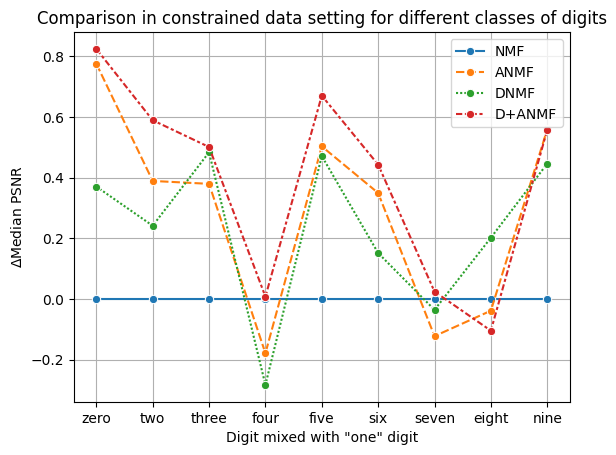

In [10]:
data_poor_df = pd.read_csv('csv/data_poor_tuning.csv', index_col = 0)

new_df = data_poor_df.copy(deep = True)
for column in new_df:
    if column != "M":
        new_df[column] = new_df[column] - data_poor_df["std"]
ax = seaborn.lineplot(data = new_df.drop("M", axis = 1).drop("exem", axis = 1), marker = 'o')
ax.set_xticklabels(['','zero', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'])
ax.set_xlabel('Digit mixed with "one" digit')
ax.set_ylabel(r"$\Delta$" + "Median PSNR")
plt.title("Comparison in constrained data setting for different classes of digits")
plt.legend(labels = ["NMF", "_nolegend_", "ANMF", "_nolegend_", "DNMF", "_nolegend_", "D+ANMF"])
plt.grid()
plt.savefig('fig/data_poor.pdf')
plt.show()


We see that D+ANMF outperforms the other methods for almost all digits, with ANMF and DNMF not for behind. For the digits four, seven and eight, there is little performance gain from more complex models. It is worth noting that DNMF uses less data and also has a simpler parameter selection, so it is impressive that it is able to perform competitively.

While D+ANMF can potentially utilize all available data
and provide the best fits, it comes with added computational complexity and a more difficult parameter selection. 
The same is true, if to a lesser extent, for ANMF. 
The difficulty of selecting good parameters implies the need of some heuristic method for parameter selection in cases where performing a random search
is not feasible.

The conclusion is that all methods have their advantages and disadvantages when it comes to computational complexity, performance,
difficulty of parameter selection and usability in different data settings. The results overall imply that methods that utilize more data
tend to perform better, and that adversarial fitting is a good idea for source separation problems. 